In [48]:
%pip install pandas scikit-learn numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import random
from sklearn.neighbors import BallTree
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Константы
BS_TYPE_1_RADIUS = 1.0  # Радиус для БС типа 1 (км)
BS_TYPE_2_RADIUS = 2.0  # Радиус для БС типа 2 (км)
BS_TYPE_1_MAX_DEVICES = 2000
BS_TYPE_2_MAX_DEVICES = 10000
BS_TYPE_1_COST = 50000
BS_TYPE_2_COST = 180000

In [4]:
# Загрузка данных
houses_data = pd.read_csv('./task.csv', delimiter=';')
houses_data

,house_uuid,latitude,longitude,end_devices_count
0,b885de0f-09df-441f-85a6-bb28b468cea2,54.280637,48.310075,60
1,ac845abb-39e4-4b59-b1ca-d01a6b883b6a,54.327441,48.388516,35
2,fcbdc6c9-8c50-4a9d-9f2a-3da4f0d8432b,54.333380,48.491670,38
3,837ff3e3-6b90-459b-926d-230dcf8a7169,53.650325,47.114310,22
4,00588c27-989b-4d05-bf28-872c37831c9f,54.273530,48.286130,101
...,...,...,...,...
5750,c4e0ce30-df67-49e3-a9ab-b54264293bf7,54.226301,48.093087,24
5751,7992d45d-2e74-4f4b-b7c0-85ce5a7d8056,54.277110,48.282410,66
5752,41924162-917f-45c4-b2dd-2c2e5069cfce,54.327908,48.486855,180
5753,8b62ab41-dc72-4bfe-aa2f-6f564d7e0b07,54.275023,48.331051,12


In [5]:
# Перевод широты и долготы домов в радианы для использования с BallTree
stations = np.deg2rad(houses_data[['latitude', 'longitude']])
tree = BallTree(stations, metric='haversine')  # Используем haversine расстояние

In [6]:
# Радиусы в радианах
BS_TYPE_1_RADIUS_RAD = BS_TYPE_1_RADIUS / 6371.0  # 6371 км - радиус Земли
BS_TYPE_2_RADIUS_RAD = BS_TYPE_2_RADIUS / 6371.0

In [28]:
# Функция для поиска домов, попадающих в радиус станции
def get_coverage_indices(lat, lon, tree, radius_rad):
    point = np.deg2rad([[lat, lon]])
    # print('point', point)
    indices = tree.query_radius(point, r=radius_rad)[0]
    # print('houses_data', indices[0])
    return indices

# Жадный алгоритм выбора станций
def greedy_station_placement(houses_data, tree):
    remaining_houses = set(houses_data.index)  # Дома, которые нужно покрыть
    placed_stations = []  # Список установленных станций (индекс дома, тип станции)
    old_remaining_houses = 0
    cnt_diff_remaining_houses = 0
    while remaining_houses:
        # print(len(remaining_houses), old_remaining_houses)
        best_station = None
        best_coverage = set()
        best_type = None
        best_cost = float('inf')
        if old_remaining_houses == len(remaining_houses):
            cnt_diff_remaining_houses += 1
        old_remaining_houses = len(remaining_houses)
        # Проверяем возможность установки каждой станции (типы 1 и 2)
        for idx, house in houses_data.loc[houses_data.index[list(random.sample(list(remaining_houses), min(10, len(remaining_houses))))]].iterrows():
            if idx not in remaining_houses:
                continue
            
            lat, lon = house['latitude'], house['longitude']

            # Покрытие станцией типа 1
            coverage_indices_1 = get_coverage_indices(lat, lon, tree, BS_TYPE_1_RADIUS_RAD)
            coverage_1 = set(coverage_indices_1) & remaining_houses
            total_devices_1 = houses_data.loc[list(coverage_1), 'end_devices_count'].sum()
            
            if total_devices_1 <= BS_TYPE_1_MAX_DEVICES and BS_TYPE_1_COST < best_cost:
                best_station = idx
                best_coverage = coverage_1
                best_type = 1
                best_cost = BS_TYPE_1_COST

            # Покрытие станцией типа 2
            coverage_indices_2 = get_coverage_indices(lat, lon, tree, BS_TYPE_2_RADIUS_RAD)
            coverage_2 = set(coverage_indices_2) & remaining_houses
            total_devices_2 = houses_data.loc[list(coverage_2), 'end_devices_count'].sum()
            
            if total_devices_2 <= BS_TYPE_2_MAX_DEVICES and BS_TYPE_2_COST < best_cost:
                best_station = idx
                best_coverage = coverage_2
                best_type = 2
                best_cost = BS_TYPE_2_COST
        if cnt_diff_remaining_houses > 2:
            cnt_diff_remaining_houses = 0
            pre_best = random.choice(list(remaining_houses))
            placed_stations.append((houses_data.iloc[pre_best]['house_uuid'], random.randint(1, 2)))
            remaining_houses -= set(random.sample(list(remaining_houses), min(random.randint(10, 50), len(remaining_houses)))) & remaining_houses
            continue

        # Размещаем лучшую станцию
        if best_station is not None:
            placed_stations.append((houses_data.iloc[best_station]['house_uuid'], best_type))
            remaining_houses -= best_coverage
            
    return placed_stations

In [29]:
# Запуск алгоритма
placed_stations = greedy_station_placement(houses_data, tree)

In [9]:
# Запись результатов в CSV
result_df = pd.DataFrame(placed_stations, columns=['house_uuid', 'type'])
result_df.to_csv('result.csv', index=False, sep=';')

In [ ]:
# result_df['type'].count()
# result_df[(result_df['type'] == 2)].count()

house_uuid    48
type          48
dtype: int64

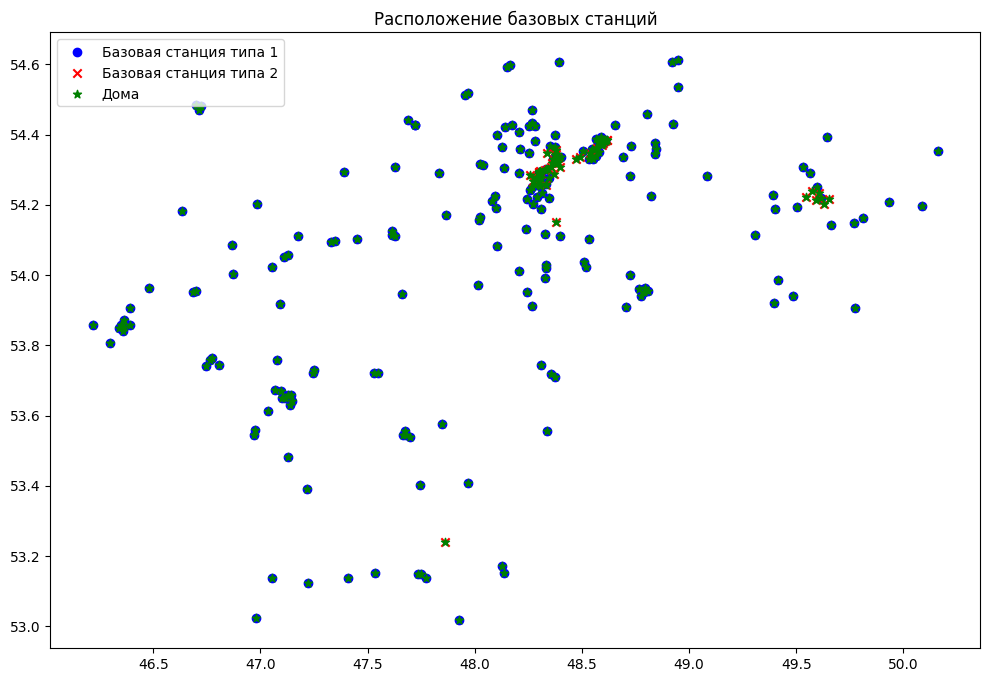

In [30]:
# Загрузка результата решения
result_df = pd.read_csv("./result.csv", sep=';')

# Чтение координат всех домов
houses_df = pd.read_csv("./task.csv", sep=';')
houses_df.dropna(inplace=True)

# Объединение данных о станциях с координатами домов
merged_df = result_df.merge(houses_df, how="left", left_on="house_uuid", right_on="house_uuid")

# Создание графика
fig, ax = plt.subplots(figsize=(12, 8))



# Отображение базовых станций
bs_1 = merged_df.query("type == 1")
bs_2 = merged_df.query("type == 2")

ax.scatter(bs_1["longitude"], bs_1["latitude"], marker='o', color='blue', label='Базовая станция типа 1')
ax.scatter(bs_2["longitude"], bs_2["latitude"], marker='x', color='red', label='Базовая станция типа 2')
# Отображение всех домов
ax.scatter(merged_df["longitude"], merged_df["latitude"], marker='*', color='green', label='Дома')

# Настройка легенды и заголовка
plt.legend(loc='upper left')
plt.title("Расположение базовых станций")

# Показать график
plt.show()